# Getting Started Comparing Hand Annotated Blinks with OF and Glasses
We've hand annotated some of Patrick 3 with the 'Hand Annotate Videos' script, now let's see how we did.

We need to load in our hand annotations `hand_annotations` from `hand_annotations.p`, which is a dictionary with key = index of video session, value = array of timestamps of hand labels.

We need to load in our video sessions with the openface labels `vid_meta_data` from `video_blink_sessions.p`.  We'll just use the sessions we have hand annotations for.

We need to load in our glasses blink data, time corrected.  We can either load in
- (1) the results from our baseline classifier df, which is a df that includes a timestamp, duration, and peak velocities for each blink we identified, from `glasses_all_blink_timestamps_uncorrected.p`.  This is without the timestamp correction to align it with video, so we also need to load and apply `best_offset.p` to time align the blinks properly.
- (2) we could load in the raw `blink_sess` from `sessions_blink.p`, which is the raw data right off the sensor.  This is also not time corrected and we'll need to apply `best_offset.p`

Finally, we may need to load in `sessions_accel.p` if it turns out we need to use the accelerometer data to try and remove blink artifacts based on motion.  Again, this glasses data will need to have `best_offset.p` applied to its timestamps before using it.

In [32]:
import json
from datetime import datetime , timezone
import time
import numpy as np
import codecs
import struct
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pycorrelate
import collections
import itertools
from mpl_toolkits import mplot3d
import cv2
import imutils
import os
from scipy.spatial.transform import Rotation as R

pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', 1000)
%matplotlib inline

### Step 1: Load Data (and correct glasses time offset to align everything)

In [213]:
metadata = pickle.load(open('./cleaned_data/metadata.p', 'rb'))
print('Please Choose a Session to Work With:')
for k in metadata: print(k, end=',  ')

Please Choose a Session to Work With:
david_2,  patrick_1,  patrick_2,  beata_1,  david_3b,  irmandy_1,  juliana_1,  irmandy_2,  patrick_3,  

In [247]:
#TODO 

SESSION = 'juliana_1'

In [248]:
hand_annotations = pickle.load(open('./cleaned_data/' + SESSION + '/hand_annotations.p', "rb" ))

vid_meta_data = pickle.load(open('./cleaned_data/' + SESSION + '/video_blink_sessions.p', "rb" ))

best_offset = pickle.load(open('./cleaned_data/' + SESSION + '/best_offset.p', "rb" ))

accel_sess = pickle.load(open('./cleaned_data/' + SESSION + '/sessions_accel.p', "rb" ))
for i in range(len(accel_sess)): accel_sess[i]['timestamp_ms'] = accel_sess[i]['timestamp_ms'] + best_offset

In [249]:
total_blinks, total_dur_sec, total_num_skipped, total_dur_skipped, of_blinks_skipped = 0, 0, 0, 0, 0
for k in hand_annotations:
    try:
        total_blinks += len(hand_annotations[k])
        total_dur_sec += vid_meta_data['duration_sessions_sec'][k]
    except:
        total_num_skipped +=1
        total_dur_skipped += vid_meta_data['duration_sessions_sec'][k]
        of_blinks_skipped += vid_meta_data['blinks_per_session'][k]

print('hand annotations represent %d blinks with %3.2f secs of recording.  That\'s a blink rate of %2.2f blinks/min.'%(total_blinks, total_dur_sec, 60*total_blinks/total_dur_sec))
print('skipped %d snippets with %3.2f sec of recording.  These are probably worse for OF because they were hard to classify by eye.'%(total_num_skipped, total_dur_skipped))
print('skipped sections include %d blinks found by openface.'%of_blinks_skipped)

hand annotations represent 516 blinks with 498.80 secs of recording.  That's a blink rate of 62.07 blinks/min.
skipped 3 snippets with 263.56 sec of recording.  These are probably worse for OF because they were hard to classify by eye.
skipped sections include 26 blinks found by openface.


#### Now we will eliminate the sections we skipped when hand annotating
We skipped some sections during annotation because of the ambiguity/difficulty and saved them as 'None'.  OF would likely struggle with these, but we can't even really tell ourselves; OF shouldn't have been confident.  We'll work just with our known good data now and eliminate values of 'None' from our hand annotations.

In [250]:
filtered = {k: v for k, v in hand_annotations.items() if v is not None}
hand_annotations.clear()
hand_annotations.update(filtered)

In [219]:
def string_to_timestamp_ms(datestring):
    return datetime.strptime(datestring, '%m/%d/%y %I:%M:%S%p %Z').timestamp()*1000

for k in hand_annotations: print(k, (vid_meta_data['session_times'][k][0]- string_to_timestamp_ms(metadata[SESSION]['vid_start']))/60000)

#irmandy_2
#del hand_annotations[97]

#beata_1
#del hand_annotations[359]
#del hand_annotations[607]

print('------')
for k in hand_annotations: print(k, (vid_meta_data['session_times'][k][0]- string_to_timestamp_ms(metadata[SESSION]['vid_start']))/60000)


359 163.5287
72 20.71998333333333
122 45.40088333333333
352 151.55278333333334
232 108.17171666666667
353 154.3125
8 1.6789166666666666
618 230.44175
610 224.65426666666667
123 48.2404
627 240.45958333333334
46 13.531933333333333
111 41.276466666666664
50 15.590666666666667
334 144.96533333333332
625 238.75231666666667
333 143.41155
1836 468.23338333333334
607 221.96378333333334
------
72 20.71998333333333
122 45.40088333333333
352 151.55278333333334
232 108.17171666666667
353 154.3125
8 1.6789166666666666
618 230.44175
610 224.65426666666667
123 48.2404
627 240.45958333333334
46 13.531933333333333
111 41.276466666666664
50 15.590666666666667
334 144.96533333333332
625 238.75231666666667
333 143.41155
1836 468.23338333333334


### Step 2: For simplicity, add motion to df_glasses_blinks and remove accel_sess, since we won't need it anymore

In [251]:
def df_between_timestamps(df, time_col, start_time, end_time):
    return df[(start_time <= df[time_col]) & (df[time_col] <= end_time)].copy()

def rotation_mag_between_rows(row_start, row_end):
    rotation = R.from_quat(row_start[['quatReal', 'quatI', 'quatJ', 'quatK']]).inv() * R.from_quat(row_end[['quatReal', 'quatI', 'quatJ', 'quatK']])
    return rotation.magnitude()
    
def get_rotation_mag_by_timestamp(timestamp):
    for sess in accel_sess:
        #if our timestamp is in this session
        if sess['timestamp_ms'].iloc[0] <= timestamp <= sess['timestamp_ms'].iloc[-1]:
            #get the two closest timestamps
            df_closest = sess.iloc[(sess['timestamp_ms']-timestamp).abs().argsort()[:2]]
            #return the rotation of these two
            return rotation_mag_between_rows(df_closest.iloc[0], df_closest.iloc[1])
    #if we fail to find it in our glasses data for acceleration, return np.nan
    return np.nan

We now have clean, easy to use and work with data that is all time aligned!

`vid_meta_data` - a dict with sessions of good tracking from OF, timestamped at the start and end, as well as lists of timestamps of blink events.

`hand_annotations` - a dict where the key indexes the session from `vid_meta_data`, and the value is a list of timestamps of blink events.

`df_glasses_blinks` - a df where every row represents a blink captured by our glasses/basic glasses algorithm, timestamped, and including blink duration, vel_open, vel_close, and rotation_magnitude of the head during that blink.

### Step 3: Compare Hand Annotations with Blink Classification from OF and the Glasses

We'll start by simply: 

(1) printing basic hand annotation data (duration annotated, blinks/sec, number of sessions, number of blinks, etc)

(2) reducing our blink list for glasses and video into one list for each, which only includes blinks that occur during our hand anotation sections.

(3) comparing the OF list and the glasses list to the hand annotation list.  Iterate over real blink times, removing first instance of classified blink that falls within some error bar.  Get metrics for true/false positives and compare.

(4) store indices of glasses blinks that are false positives, and create a df for true positives and false positives.  Look at differences between vel/duration/rotation_mag when true or false positive.

(5) plot(?) each over top of one another?  May be useful



In [253]:

def grab_blinks(blink_sess, thresh=0.06, blink_dur_ms=175, lpf_samples=50, dx_lpf_samples=25, reverse=False):
    #get array of (1)timestamps of blinks, (2) [peak close velocity, peak open velocity], (3) duration
    
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'same') / w
    
    #step 1: LPF input, take derivative, LPF derivative
    smooth_input = moving_average(blink_sess['value'], lpf_samples)
    dx = np.append([np.nan], np.diff(smooth_input))
    smooth_dx = moving_average(dx, dx_lpf_samples)
    df_results = pd.DataFrame({'timestamp_ms':blink_sess['timestamp_ms'], 'dx':smooth_dx})
    
    #step 2, apply threshold
    if reverse:
        decision = (smooth_dx > thresh)
    else:
        decision = (smooth_dx < -1*thresh)

    #plt.plot(df_results['timestamp_ms'], df_results['dx'])
    #plt.plot(df_results['timestamp_ms'], decision)
    #plt.show()
    
    #step 3, use this thresholded value to decide if we are blinking subject to debounce.
    #grab the blink time. within the bounds of the blink, find the duration and peak velocities using the derivative.
    df_blinks = pd.DataFrame()
    samples_per_blink = int(blink_dur_ms)  # happen to sample at 1kHz so 1 sample == 1 ms
    samples_blink_debounce = int(samples_per_blink/2)
    i, blinkrow = 0, {}
    while i<len(decision):
        if decision[i]: #we have a blink
            blinkrow['timestamp_ms'] = df_results['timestamp_ms'].iloc[i] #timestamp of this blink
            
            df_thisblink = df_results.iloc[i:i+samples_per_blink] #grab the data associated with this blink
            if reverse:
                max_close = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].max()]
                max_open  = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].min()]
            else:
                max_close = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].min()]
                max_open  = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].max()]
            
            blinkrow['vel_close'] = abs(max_close['dx'].iloc[0]) #peak close velocity
            blinkrow['vel_open']  = abs(max_open['dx'].iloc[-1]) #peak open velocity
            blinkrow['duration_ms'] = max_open['timestamp_ms'].iloc[-1] - max_close['timestamp_ms'].iloc[0] #duration
            
            df_blinks = df_blinks.append(blinkrow, ignore_index=True)
            i += samples_blink_debounce #move ahead debounce samples before checking for blinks again
        else: i += 1
            
    return df_blinks

def get_all_blink_sessions(blink_sessions, thresh=0.06, blink_dur_ms=250, lpf_samples=50, dx_lpf_samples=25, reverse=False):
    
    df_result = pd.DataFrame()
    for sess in blink_sessions:
        df_blinks = grab_blinks(sess,
                                thresh=thresh, 
                                blink_dur_ms=blink_dur_ms, 
                                lpf_samples=lpf_samples, 
                                dx_lpf_samples=dx_lpf_samples, 
                                reverse=reverse)
        df_result = df_result.append(df_blinks, ignore_index=True)
        
    return df_result

In [254]:
def debounce_data(list_of_times, debounce_dur_ms=200):
    
    indices_to_remove = []
    for i in range(1, len(list_of_times)):
        if list_of_times[i-1] >= list_of_times[i] - debounce_dur_ms:
            indices_to_remove.append(i)

    for index in sorted(indices_to_remove, reverse=True):
        del list_of_times[index]
        
    return list_of_times

def test_results(annotated_blinklist, test_blinklist, tolerance_ms=400):
    results = {'true_pos':0, 'real_pos':len(annotated_blinklist)}

    for  atime in annotated_blinklist:
        for ttime in test_blinklist:
            if ttime-tolerance_ms <= atime <= ttime+tolerance_ms:
                results['true_pos'] += 1
                test_blinklist.remove(ttime)
                break
    results['false_pos'] = len(test_blinklist)
    results['sensitivity'] = results['true_pos'] / results['real_pos'] * 100
    results['false_discovery'] = results['false_pos'] / (results['false_pos'] + results['true_pos']) * 100
    
    return results, test_blinklist

In [ ]:
blink_sess = pickle.load(open('./cleaned_data/' + SESSION + '/sessions_blink.p', 'rb'))

blink_durs = [175, 300]
threshs = [0.035, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16]
#threshs = [0.1, 0.12, 0.14, 0.16]
margins = [400, 500, 1000, 1100, 1300, 1400]

best_diff = 0
worst_diff = 100
combined_diff = 0

for blink_dur, thresh, margin in itertools.product(blink_durs, threshs, margins):

    print('TESTING: ',thresh, margin, blink_dur,'------')
    
    df_glasses_blinks = get_all_blink_sessions(blink_sess, thresh=thresh, blink_dur_ms=blink_dur, lpf_samples=100, dx_lpf_samples=50)
    df_glasses_blinks['timestamp_ms'] = df_glasses_blinks['timestamp_ms'] + best_offset

    glasses_blinks_during_handannotate_times = []
    vblinks, ablinks = [], []
    for i in hand_annotations:
        glasses_blinks_during_handannotate_times.append(df_between_timestamps(df_glasses_blinks, 
                                                      'timestamp_ms', 
                                                      vid_meta_data['session_times'][i][0], 
                                                      vid_meta_data['session_times'][i][1]))

        vblinks.extend(vid_meta_data['blink_timestamps_per_session'][i])
        ablinks.extend(hand_annotations[i])

    df_gblinks = pd.concat(glasses_blinks_during_handannotate_times)
    gblinks = df_gblinks['timestamp_ms'].tolist()    
    
    r, _ = test_results(ablinks, gblinks, margin)
    diff1 = (r['sensitivity']-r['false_discovery'])
    if round(diff1*5) >= best_diff:
        best_diff = round(diff1*5)
        print('\t\t   GLASS sens: %2.1f \tfalse: %2.1f \tdiff: %2.1f ++'%(r['sensitivity'], r['false_discovery'], diff1))
    else:
        print('\t\t   GLASS sens: %2.1f \tfalse: %2.1f \tdiff: %2.1f'%(r['sensitivity'], r['false_discovery'], diff1))
    r, _ = test_results(ablinks, vblinks, margin)
    diff2 = (r['sensitivity']-r['false_discovery'])
    if round(diff2*5) <= worst_diff:
        worst_diff = round(diff2*5)
        print('\t\tOPENFACE sens: %2.1f \tfalse: %2.1f \tdiff: %2.1f ++'%(r['sensitivity'], r['false_discovery'], diff2))
    else:
        print('\t\tOPENFACE sens: %2.1f \tfalse: %2.1f \tdiff: %2.1f'%(r['sensitivity'], r['false_discovery'], diff2))
    if (diff1-diff2) >= combined_diff:
        combined_diff = (diff1-diff2)
        print('\t\t                     \t             \t           ++++')
        

TESTING:  0.035 400 175 ------
		   GLASS sens: 85.9 	false: 53.7 	diff: 32.2 ++
		OPENFACE sens: 31.4 	false: 36.0 	diff: -4.6 ++
		                     	             	           ++++
TESTING:  0.035 500 175 ------
		   GLASS sens: 89.9 	false: 51.5 	diff: 38.5 ++
		OPENFACE sens: 33.5 	false: 31.6 	diff: 1.9
TESTING:  0.035 1000 175 ------
		   GLASS sens: 99.6 	false: 46.2 	diff: 53.4 ++
		OPENFACE sens: 38.4 	false: 21.7 	diff: 16.6
TESTING:  0.035 1100 175 ------
		   GLASS sens: 100.0 	false: 46.0 	diff: 54.0 ++
		OPENFACE sens: 39.7 	false: 19.0 	diff: 20.8
TESTING:  0.035 1300 175 ------
		   GLASS sens: 100.0 	false: 46.0 	diff: 54.0 ++
		OPENFACE sens: 40.5 	false: 17.4 	diff: 23.1
TESTING:  0.035 1400 175 ------
		   GLASS sens: 100.0 	false: 46.0 	diff: 54.0 ++
		OPENFACE sens: 41.3 	false: 15.8 	diff: 25.5
TESTING:  0.04 400 175 ------
		   GLASS sens: 83.9 	false: 49.7 	diff: 34.2
		OPENFACE sens: 31.4 	false: 36.0 	diff: -4.6 ++
		                     	             	    

# RUN TO HERE
get best margin, blink_dur, and thresh

In [232]:
BEST_MARGIN = 1400
THRESH = 0.1
BLINK_DUR = 300

In [233]:
df_glasses_blinks = get_all_blink_sessions(blink_sess, thresh=THRESH, blink_dur_ms=BLINK_DUR)
df_glasses_blinks['timestamp_ms'] = df_glasses_blinks['timestamp_ms'] + best_offset

glasses_blinks_during_handannotate_times = []
vblinks, ablinks = [], []
for i in hand_annotations:
    glasses_blinks_during_handannotate_times.append(df_between_timestamps(df_glasses_blinks, 
                                                  'timestamp_ms', 
                                                  vid_meta_data['session_times'][i][0], 
                                                  vid_meta_data['session_times'][i][1]))

    vblinks.extend(vid_meta_data['blink_timestamps_per_session'][i])
    ablinks.extend(hand_annotations[i])

df_gblinks = pd.concat(glasses_blinks_during_handannotate_times)
gblinks = df_gblinks['timestamp_ms'].tolist()

In [234]:
#gblinks_debounce = debounce_data(gblinks)
gresults, false_pos_times = test_results(ablinks, gblinks, BEST_MARGIN)
print('glasses: ',gresults)

vresults, _ = test_results(ablinks, vblinks, BEST_MARGIN)
print('openface:',vresults)

glasses:  {'true_pos': 263, 'real_pos': 364, 'false_pos': 91, 'sensitivity': 72.25274725274726, 'false_discovery': 25.70621468926554}
openface: {'true_pos': 194, 'real_pos': 364, 'false_pos': 268, 'sensitivity': 53.2967032967033, 'false_discovery': 58.00865800865801}


In [235]:
df_gblinks['asym'] = df_gblinks['vel_close']-df_gblinks['vel_open']
df_gblinks['weighted_asym'] = (df_gblinks['vel_close']-df_gblinks['vel_open'])/(df_gblinks['vel_close']+df_gblinks['vel_open'])

df_gblinks.head()

,duration_ms,timestamp_ms,vel_close,vel_open,asym,weighted_asym
273,134.000,1617381439468.000,0.151,0.112,0.039,0.148
274,158.000,1617381455715.000,0.170,0.104,0.066,0.242
275,162.000,1617381463516.000,0.178,0.090,0.087,0.326
276,109.000,1617381468017.000,0.141,0.115,0.027,0.104
277,155.000,1617381479391.000,0.173,0.086,0.087,0.338


In [236]:
gblinks_success = df_gblinks[~df_gblinks['timestamp_ms'].isin(false_pos_times)]
gblinks_failed  = df_gblinks[df_gblinks['timestamp_ms'].isin(false_pos_times)]

In [237]:
print(len(gblinks_success))
print(len(gblinks_failed))

263
91


<AxesSubplot:>

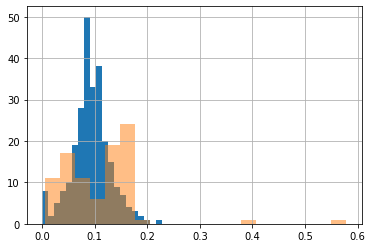

In [238]:
gblinks_success['vel_open'].hist(bins=20)
gblinks_failed['vel_open'].hist(bins=20,alpha=0.5)

<AxesSubplot:>

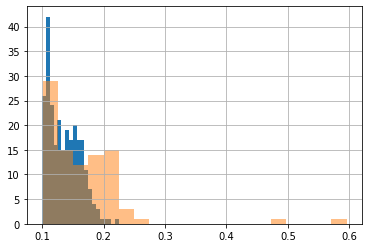

In [239]:
gblinks_success['vel_close'].hist(bins=20)
gblinks_failed['vel_close'].hist(bins=20,alpha=0.5)

<AxesSubplot:>

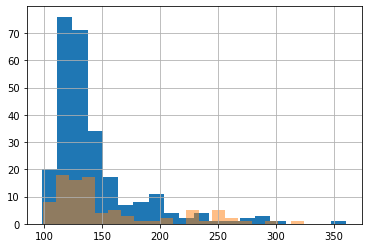

In [240]:
gblinks_success['duration_ms'].hist(bins=20)
gblinks_failed['duration_ms'].hist(bins=20,alpha=0.5)

<AxesSubplot:>

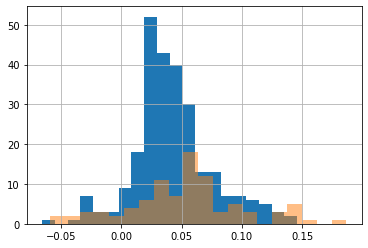

In [241]:
gblinks_success['asym'].hist(bins=20)
gblinks_failed['asym'].hist(bins=20, alpha=0.5)

<AxesSubplot:>

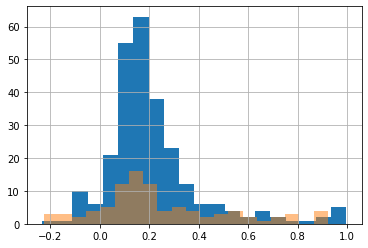

In [242]:
gblinks_success['weighted_asym'].hist(bins=20)
gblinks_failed['weighted_asym'].hist(bins=20, alpha=0.5)

In [243]:
#lets filter our blink list by IF vel_close < 0.12 and/or vel_open < 0.05 and retest
gblinks = df_gblinks['timestamp_ms'].tolist()
#gblinks_filtered1 = df_gblinks[(df_gblinks['vel_open'] > 0.05) & (df_gblinks['vel_close'] > 0.12)]['timestamp_ms'].tolist()
#gblinks_filtered2 = df_gblinks[(df_gblinks['vel_open'] > 0.05) | (df_gblinks['vel_close'] > 0.12)]['timestamp_ms'].tolist()
gblinks_filtered1 = df_gblinks[(df_gblinks['weighted_asym'] < 0.5) & (df_gblinks['weighted_asym'] > 0.0)]['timestamp_ms'].tolist()
gblinks_filtered2 = df_gblinks[(df_gblinks['duration_ms'] > 50) & (df_gblinks['vel_open'] < 0.4) & (df_gblinks['vel_close'] < 0.4)]['timestamp_ms'].tolist()




print('filtered out', len(gblinks)-len(gblinks_filtered1),'results')
gresults, false_pos_times = test_results(ablinks, gblinks, BEST_MARGIN)

print('original glasses: ',gresults)
gresults, false_pos_times = test_results(ablinks, gblinks_filtered1, BEST_MARGIN)
print('filtered glasses: ',gresults)
gresults, false_pos_times = test_results(ablinks, gblinks_filtered2, BEST_MARGIN)
print('filtered glasses: ',gresults)

filtered out 66 results
original glasses:  {'true_pos': 263, 'real_pos': 364, 'false_pos': 91, 'sensitivity': 72.25274725274726, 'false_discovery': 25.70621468926554}
filtered glasses:  {'true_pos': 232, 'real_pos': 364, 'false_pos': 56, 'sensitivity': 63.73626373626373, 'false_discovery': 19.444444444444446}
filtered glasses:  {'true_pos': 263, 'real_pos': 364, 'false_pos': 89, 'sensitivity': 72.25274725274726, 'false_discovery': 25.28409090909091}


In [244]:
gblinks = df_gblinks['timestamp_ms'].tolist()
gblinks_filtered1 = df_gblinks[(df_gblinks['vel_open'] > 0.05) | (df_gblinks['vel_close'] > 0.12)]['timestamp_ms'].tolist()
#gblinks_filtered2 = df_gblinks[((df_gblinks['vel_open'] > 0.06) | (df_gblinks['vel_close'] > 0.12)) & (df_gblinks['rotation_magnitude'] < 0.05)]['timestamp_ms'].tolist()


print('filtered out', len(gblinks)-len(gblinks_filtered1),'results')
gresults, false_pos_times = test_results(ablinks, gblinks, BEST_MARGIN)

print('original glasses: ',gresults)
gresults, false_pos_times = test_results(ablinks, gblinks_filtered1, BEST_MARGIN)
print('filtered glasses: ',gresults)
#gresults, false_pos_times = test_results(ablinks, gblinks_filtered2, BEST_MARGIN)
#print('filtered glasses: ',gresults)

filtered out 18 results
original glasses:  {'true_pos': 263, 'real_pos': 364, 'false_pos': 91, 'sensitivity': 72.25274725274726, 'false_discovery': 25.70621468926554}
filtered glasses:  {'true_pos': 253, 'real_pos': 364, 'false_pos': 83, 'sensitivity': 69.5054945054945, 'false_discovery': 24.702380952380953}


In [245]:
#lets save our results!
final_results = {}

vblinks = []
for i in hand_annotations: vblinks.extend(vid_meta_data['blink_timestamps_per_session'][i])
vresults, _ = test_results(ablinks, vblinks, BEST_MARGIN)
final_results['openface'] = vresults

gblinks = df_gblinks['timestamp_ms'].tolist()
gresults, _ = test_results(ablinks, gblinks, BEST_MARGIN)
final_results['glasses'] = gresults

gblinks_filtered = df_gblinks[(df_gblinks['vel_open'] > 0.05) | (df_gblinks['vel_close'] > 0.12)]['timestamp_ms'].tolist()
gresults, _ = test_results(ablinks, gblinks_filtered, BEST_MARGIN)
final_results['glasses_filtered'] = gresults

print(final_results)

{'openface': {'true_pos': 194, 'real_pos': 364, 'false_pos': 268, 'sensitivity': 53.2967032967033, 'false_discovery': 58.00865800865801}, 'glasses': {'true_pos': 263, 'real_pos': 364, 'false_pos': 91, 'sensitivity': 72.25274725274726, 'false_discovery': 25.70621468926554}, 'glasses_filtered': {'true_pos': 253, 'real_pos': 364, 'false_pos': 83, 'sensitivity': 69.5054945054945, 'false_discovery': 24.702380952380953}}


In [246]:
final_results['best_margin'] = BEST_MARGIN
final_results['applied_thresh'] = THRESH
pickle.dump(final_results, open( './cleaned_data/' + SESSION + '/final_results_handtuned.p', "wb" ))

In [ ]:
#irmandy with 50/25, beata with 100/50